In [1]:
### SETTING UP THE DATAFRAME ###

In [1151]:
#Importing relevant modules: 
# * dataframe - pandas 
# * graphs - matplotlib 
# * tools - numpy, random, fnmatch, os
# * fasta to dataframe conversion - SeqIO

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd
import random
import collections
import math
from pandas.tools.plotting import table
from itertools import product
from Bio import SeqIO
from ete3 import NCBITaxa

In [3]:
work_dir = '/home/gamran/dirtreetest/'

In [398]:
#Functions that generate main work directories and subdirectories for:
# * data (all fasta files)
# * blast (all blast output files)
# * analysis (all dataframe summary and graph files)
# When given a top directory path

def create_main_directories(top_dir):
    """Given a top work directory, creates 3 main subdirectories - data, blast and analysis"""
    main_directory_list = ['data/', 'blast/', 'analysis/']
    for new_direct in main_directory_list:
        if not os.path.exists(top_dir + new_direct):
            os.makedirs(top_dir + new_direct)

def create_data_subdirectories(top_dir):
    data_subdirectory_list = ['basecalled/',
                        'rghityes/',
                        'rghitno/',
                        'rghitsamples/']
    data_subsubdirectory_list = ['ncbihityes/',
                                 'ncbihitno/']
    for new_subdirect in data_subdirectory_list:
        if not os.path.exists(top_dir + 'data/' + new_subdirect):
            os.makedirs(top_dir + 'data/' + new_subdirect)
    for new_subsubdirect in data_subsubdirectory_list:
        if not os.path.exists(top_dir + 'data/rghitno/' + new_subsubdirect):
            os.makedirs(top_dir + 'data/rghitno/' + new_subsubdirect)

def create_blast_subdirectories(top_dir):
    blast_subdirectory_list = ['rgbesthit/',
                               'ncbibesthit/']
    for new_subdirect in blast_subdirectory_list:
        if not os.path.exists(top_dir + 'blast/' + new_subdirect):
            os.makedirs(top_dir + 'blast/' + new_subdirect)

def create_analysis_subdirectories(top_dir):
    analysis_subdirectory_list = ['graphs/',
                                  'tables/',
                               'summaries/']
    for new_subdirect in analysis_subdirectory_list:
        if not os.path.exists(top_dir + 'analysis/' + new_subdirect):
            os.makedirs(top_dir + 'analysis/' + new_subdirect)

In [400]:
#Apply previous functions to generate data, blast and analysis directories and subdirectories:
create_main_directories(work_dir)
create_data_subdirectories(work_dir)
create_blast_subdirectories(work_dir)
create_analysis_subdirectories(work_dir)

In [ ]:
#Create a function that moves all basecalled fasta files to the ./basecalled folder, given input

In [89]:
#Generates a list of all the fasta files present in data/basecalled
os.chdir(work_dir + 'data/')
#os.curdir
#os.getcwd()

basecalled_file_names = [x for x in list(os.walk('./basecalled', topdown=False))]

In [958]:
#Reduces basecalled_file_names to a flattened list, extracts all basecalled fasta file names
def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el

In [960]:
fasta_file_type = '.fa' 
basecalled_file_names_flattened = list(flatten(basecalled_file_names))
basecalled_fasta_file_names = [x for x in basecalled_file_names_flattened if fasta_file_type in x]
basecalled_fasta_file_names.sort()

In [835]:
#Make a list of all available barcodes, based on fasta file names
basecalled_fasta_barcodes = []
for bcs in range(0, len(basecalled_fasta_file_names)):
    bclabel_index = ''
    if int(basecalled_fasta_file_names[bcs].rfind('BC')) > int(basecalled_fasta_file_names[bcs].rfind('NB')):
        bclabel_index = int(basecalled_fasta_file_names[bcs].rfind('BC'))
    else:
        bclabel_index = int(basecalled_fasta_file_names[bcs].rfind('NB'))
    basecalled_fasta_barcodes.append(basecalled_fasta_file_names[bcs][bclabel_index:bclabel_index + 4]) #Convert to a search parameter? Try this Yiheng!


In [197]:
#Specifies all good barcodes
all_barcodes = basecalled_fasta_barcodes
good_barcodes = ['BC01', 'BC02', 'BC03', 'BC04', 'BC05', 'BC06']
bad_barcodes = sorted(list(set(all_barcodes) - set(good_barcodes)))
#bad_barcodes_BC00 = [x for x in bad_barcodes if 'BC' in x]
#bad_barcodes_NB00 = [x for x in bad_barcodes if 'NB' in x]


In [928]:
#Extracts the ID from the basecalled file names (everything before BC/NB??.fa)
basecalled_fasta_file_id_list = []
for file_name in basecalled_fasta_file_names:
    bclabel_index = ''
    if int(file_name.rfind('BC')) > int(file_name.rfind('NB')):
        bclabel_index = int(file_name.rfind('BC'))
        basecalled_fasta_file_id_list.append(file_name[0:bclabel_index])
    else:
        bclabel_index = int(file_name.rfind('NB'))
        basecalled_fasta_file_id_list.append(file_name[0:bclabel_index])
    
basecalled_fasta_file_id = list(set(basecalled_fasta_file_id_list))[0]

In [210]:
#Create text file to summarise read_id, barcode and length for all basecalled reads, save in analysis/summaries/
basecalled_fasta_barcode2filename_dict = dict()

analysis_summaries_path = work_dir + 'analysis/summaries/'
complete_path_and_name = os.path.join(analysis_summaries_path, basecalled_fasta_file_id + ".lengths.txt")
lengths_txt = open(complete_path_and_name, "w")
print("Read_id,Barcode,Length,Quality", file=lengths_txt)

os.chdir(work_dir + 'data/basecalled/')
for bcs, fa_file in zip(basecalled_fasta_barcodes, basecalled_fasta_file_names):
    for seq in SeqIO.parse(open(fa_file), 'fasta'):
        if bcs in good_barcodes:
            print(seq.id + "," + bcs + "," + str(len(seq)) + "," + 'Good', file=lengths_txt)
        elif bcs in bad_barcodes:
            print(seq.id + "," + 'NB00' + "," + str(len(seq)) + "," + 'Bad', file=lengths_txt)
        else:
            continue
lengths_txt.close()

In [211]:
basecalled_df = pd.read_csv(complete_path_and_name)


In [568]:
#basecalled_df.tail()

In [ ]:
### DATAFRAME ANALYSIS - TABLE OF SUMMARY DATA ###

In [246]:
### Shows number of reads, sum, max, mean, median of read lengths per barcode, all bad barcodes sorted to NB00 ###
basecalled_df_pivot = basecalled_df.pivot_table(values='Length', 
                                                index='Barcode', 
                                                aggfunc=[len, np.sum, np.max, np.mean, np.median],
                                                fill_value=0, 
                                                margins=True)
basecalled_df_pivot.index.name = None

for clmns in ['len', 'amax', 'median']:
    basecalled_df_pivot[clmns] = basecalled_df_pivot[clmns].apply(lambda x: int(x))
basecalled_df_pivot['sum'] = basecalled_df_pivot['sum'].apply(lambda x: "{0:.3f}".format(int(x)/1000000))
basecalled_df_pivot['mean'] = basecalled_df_pivot['mean'].apply(lambda x: "{0:.2f}".format(x))
basecalled_df_pivot_formal = basecalled_df_pivot.copy() #titles have whitespace, make fancier
basecalled_df_pivot_formal.rename(columns={'len': 'Number of Reads', 
                                    'sum': 'Total Length (Mbp)',
                                    'amax': 'Max Length (bp)',
                                    'mean': 'Mean Length (bp)',
                                    'median': 'Median Length (bp)'}, inplace=True)



In [437]:
### Saves pivot table summary in analysis/tables/ folder ###
fig = plt.figure(figsize=(9,2))
ax = fig.add_subplot(1, 1, 1, frame_on=False)
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, basecalled_df_pivot_formal, loc='center')

plt.savefig(os.path.join(work_dir + 'analysis/tables/', 
                        basecalled_fasta_file_id + "_basecalled_reads_summary.png"))



In [ ]:
### DATAFRAME ANALYSIS - HISTOGRAMS OF SUMMARY DATA ###

In [268]:
#Generates a histogram showing the total read length distribution for all basecalled reads
plt.figure(figsize=(10,5))
basecalled_df.Length.hist(bins=30)

plt.title('Basecalled Reads - Total Read Length Distribution', y=1.03, fontsize='x-large', fontweight='bold')

plt.xlabel('Read Length', fontsize=16)
plt.xticks(np.arange(0, basecalled_df.Length.max() + 1, 2000))
plt.xlim([-1000, basecalled_df.Length.max() + 1000])

plt.ylabel('Read Count', fontsize=16)

for idx, clmn_name in enumerate(list(basecalled_df_pivot_formal.columns)):
    plt.annotate(clmn_name + ' = ' + str(basecalled_df_pivot_formal[clmn_name]['All']), 
                 xy=(1, 1), 
                 xycoords='axes fraction', 
                 fontsize=16, 
                 fontweight='normal',
                 xytext=(-20, -30 - 30*idx), 
                 textcoords='offset points', 
                 ha='right', 
                 va='top')
    
plt.savefig(work_dir + 'analysis/graphs/graph1.png', bbox_inches='tight')

In [359]:
#Generates a histogram showing the total read length distribution for all basecalled reads per barcode

#Assesses number of barcodes, generates necessary number of plots (even) and relevant indexing system
basecalled_barcodes = list(basecalled_df['Barcode'].unique())

if len(list(basecalled_df['Barcode'].unique())) % 2 == 0:
    no_of_subplots = len(basecalled_barcodes)
else:
    no_of_subplots = len(basecalled_barcodes) + 1

#Always 2 columns, bc-count/2 rows 
no_of_subplots_pair = [int(no_of_subplots/2), 2]

#Produce pairs of indices correlating to the coordinates of the subplots
subplot_coordinates = list(product(range(no_of_subplots_pair[0]), range(no_of_subplots_pair[1])))
subplot_coordinates_list = [list(l) for l in subplot_coordinates]
subplot_coordinates_list_rows = [i[0] for i in subplot_coordinates_list]
subplot_coordinates_list_columns = [i[1] for i in subplot_coordinates_list]

fig, ax = plt.subplots(no_of_subplots_pair[0], no_of_subplots_pair[1], figsize=(15,10))

xmax = int(basecalled_df.Length.max())

grouped = basecalled_df.groupby('Barcode')  # CHECK THIS FOR SCALABILITY, NOT ENTIRELY SURE WHAT THIS DOES
max_count_list = []
for key in grouped.groups.keys():
    max_count_list.append(np.histogram(grouped.Length.get_group(key), 50)[0].max())
max_count_list.sort()

def applyGroupHistograms(ax_ind1, ax_ind2, bcs):
    ax[ax_ind1, ax_ind2].hist(basecalled_df.groupby('Barcode')['Length'].get_group(bcs), 
                              bins=range(0, xmax, int(xmax/60)), 
                              color='green', 
                              alpha=0.8)
    ax[ax_ind1, ax_ind2].set_title(bcs)
    ax[ax_ind1, ax_ind2].set_xlabel('Read Length')
    ax[ax_ind1, ax_ind2].set_ylabel('Read Count');
    ax[ax_ind1, ax_ind2].set_xlim([-1000, basecalled_df['Length'].max() + 1000])
    ax[ax_ind1, ax_ind2].set_xticks(np.arange(0, xmax + 1, 2000))
    ax[ax_ind1, ax_ind2].set_ylim(0, max_count_list[-1]*(5/4))
    ax[ax_ind1, ax_ind2].grid(True, which='Major')
    
    for idx, clmn_name in enumerate(['Number of Reads', 'Total Length (Mbp)', 'Median Length (bp)']):
        ax[ax_ind1, ax_ind2].annotate(clmn_name + ' = ' + str(basecalled_df_pivot_formal[clmn_name][bcs]), 
                     xy=(1, 1), 
                     xycoords='axes fraction', 
                     fontsize=16, 
                     fontweight='normal',
                     xytext=(-20, -25 - 30*idx), 
                     textcoords='offset points', 
                     ha='right', 
                     va='top')

for ax_ind1, ax_ind2, bcs, in zip(subplot_coordinates_list_rows, subplot_coordinates_list_columns, bc_list):
    applyGroupHistograms(ax_ind1, ax_ind2, bcs)    

if len(list(basecalled_df['Barcode'].unique())) != 0:
    plt.delaxes(ax[subplot_coordinates_list_rows[-1], subplot_coordinates_list_columns[-1]])

plt.suptitle('Basecalled Reads - Read Length Distribution By Barcode', 
             y=1.03, 
             fontsize='x-large', 
             fontweight='bold')
plt.tight_layout()

plt.savefig(work_dir + 'analysis/graphs/graph2.png', bbox_inches='tight')

In [ ]:
### DATAFRAME ANALYSIS - COLLATION OF RGBESTHIT DATA ###

In [ ]:
#Create a function that moves all blast files to the blast/basecalled folder, given input

In [956]:
# creates a list of all the reference genome blast besthit file names
os.chdir(work_dir + 'blast/')
rgblast_file_names = [x for x in list(os.walk('./rgbesthit', topdown=False))]
rgblast_file_names_flattened = list(flatten(rgblast_file_names))
rgblast_besthit_file_names = [x for x in rgblast_file_names_flattened if 'blast.besthit' in x]
rgblast_besthit_file_names.sort()

In [1115]:
#Extracts the blast id from the rgblast hit file names
rgblast_file_id_list = []
rgblast_file_type = '.blast.besthit'
for file_name in rgblast_besthit_file_names:
    start = file_name.find(fasta_file_type)
    end = file_name.find(rgblast_file_type)
    rgblast_file_id_list.append(file_name[start+len(fasta_file_type):end])
rgblast_file_id = list(set(rgblast_file_id_list))[0]

In [560]:
#Makes a dictionary - key (barcode) : value (dataframe of rgblast hit results per barcode)
os.chdir(work_dir + 'blast/rgbesthit')
rgblast_dfs_dict = {}
blast_output_parameters = ['qseqid', 'sseqid', 'evalue', 'bitscore', 'length', 'pident', 'nident']
for besthit_file in rgblast_besthit_file_names:
    if '.blast.besthit' in besthit_file:
        key = '' #Safety 
        key = besthit_file.split('.')[0][-4:]
        rgblast_dfs_dict[key] = pd.read_table(besthit_file, delim_whitespace=True, 
                                           names=blast_output_parameters) #hardcoded
for bcs in rgblast_dfs_dict.keys():
    rgblast_dfs_dict[bcs]['barcode'] = bcs

In [561]:
# Must supply two lists of equal length, in the desired order: 
# one corresponding to unique letter combos in the sseqid ids (tags)
# one corresponding to the full names of the reference genomes used
ref_genome_tag_list = ['TGAC', 'Zymo', 'Ptri', 'Pst', 'tig']
ref_genome_species_list = ['Wheat', 
                        'Zymoseptoria tritici', 
                        'Pyrenophore tritici-repentis', 
                        'P. striformis f. sp. tritici WA', 
                        'Parastagonospora nodorum']

def assign_species_from_sseqid(x):
    for rg_tag, rg_full in zip(ref_genome_tag_list, ref_genome_species_list):    
        if rg_tag in str(x):
            return rg_full
    else:
        return 'N/A'

for bcs in rgblast_dfs_dict.keys():
    rgblast_dfs_dict[bcs]['species'] = rgblast_dfs_dict[bcs]['sseqid'].apply(assign_species_from_sseqid)


In [566]:
#Combining the BC00 reads from BLAST
if 'BC00' in rgblast_dfs_dict.keys():
    rgblast_dfs_dict['BC00']['barcode'] = 'NB00'

#Combine all the reference genome hit dataframes across all barcodes
rgblast_df_list = []
for bcs in rgblast_dfs_dict.keys():
    rgblast_df_list.append(rgblast_dfs_dict[bcs])
    
rgblast_df_joint = pd.concat(rgblast_df_list, axis=0, ignore_index=True)
rgblast_df_joint.sort_values('barcode', ascending=True, inplace=True)
rgblast_df_joint.reset_index(drop=True, inplace=True)

In [571]:
#Create a pivot table showing all reference genome hit counts for each barcode
rgblast_df_joint_pivot = rgblast_df_joint.pivot_table(values='nident', index='barcode', columns='species', aggfunc='count', fill_value=0, margins=True)
rgblast_df_joint_pivot = rgblast_df_joint_pivot.applymap(int)
rgblast_df_joint_pivot.index.name = None
rgblast_df_joint_pivot.columns.name = None

In [587]:
#Save pivot table to analysis/tables/
fig = plt.figure(figsize=(11,2))
ax = fig.add_subplot(1, 1, 1, frame_on=False)
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, rgblast_df_joint_pivot, loc='center')

plt.savefig(os.path.join(work_dir + 'analysis/tables/', 
                        basecalled_fasta_file_id + "_rgblasthit_reads_summary.png"))


In [573]:
#Removes the 'all' column (for graphing purposes)
rgblast_df_joint_pivot_noall = rgblast_df_joint_pivot.drop('All', axis=1)

In [803]:
# Construct a grouped bar chart showing the reference genome hit counts per barcode (log y axis)
def generateGBGforRGHC(dropmaxspecies=False):
    n_groups = len(rgblast_df_joint_pivot_noall.index.values)

    max_genome = str(rgblast_df_joint_pivot_noall.ix['All'].idxmax(axis=1))

    spc_list = list(rgblast_df_joint_pivot_noall.columns)
    
    if dropmaxspecies == True:
        spc_list.remove(max_genome)

    n_species_dict = {}
    for spc in spc_list:
        n_species_dict[spc] = tuple(rgblast_df_joint_pivot_noall[spc])

    n_nohit = tuple(basecalled_df_pivot['len'].values - rgblast_df_joint_pivot['All'].values)    
    
    fig, ax = plt.subplots(figsize=(7,3))

    index = np.arange(n_groups)
    bar_width = 0.13
    opacity = 0.4

    cycol = 'rgbcym'
    if dropmaxspecies == False:
        plt.bar(index - bar_width*2, 
            n_nohit, 
            bar_width,
            alpha = opacity,
            log = True,
            color = 'k',
            label = 'No Hit')

        for idx, spc in enumerate(spc_list):
            plt.bar(index - bar_width + bar_width*idx, 
                n_species_dict[spc], 
                bar_width,
                alpha = opacity,
                log = True,
                color = random.choice(cycol),
                label = spc)
    else:
        for idx, spc in enumerate(spc_list):
            plt.bar(index - bar_width + bar_width*idx, 
                n_species_dict[spc], 
                bar_width,
                alpha = opacity,
                color = random.choice(cycol),
                label = spc)
            
    def generate_upper_ylim(graph_max):
        """Takes a value, counts the digits and outputs a value corresponding to 10*digits"""
        digits = len(str(graph_max))
        round_up = 10**(digits)
        return round_up

    plt.xlabel('Barcode')
    plt.xticks(index + bar_width*1.2, tuple(rgblast_df_joint_pivot_noall.index.values))

    plt.ylabel('Number of Reads')
    if dropmaxspecies == False:
        plt.ylim(0, generate_upper_ylim(rgblast_df_joint_pivot['All'].values.max()))
    else:
        rgblast_df_joint_pivot_nomaxspecies = rgblast_df_joint_pivot_noall.copy()
        rgblast_df_joint_pivot_nomaxspecies.drop(max_genome, axis=1, inplace=True)
        rgblast_df_joint_pivot_nomaxspecies['All'] = rgblast_df_joint_pivot_nomaxspecies.sum(axis=1)
        plt.ylim(0, (rgblast_df_joint_pivot_nomaxspecies['All'].values.max()+1)/2)

    plt.title('Number of Reads Hitting Specific Reference Genomes', y=1.08)
    plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10)
    plt.grid(b=None, which='major', axis='y', linestyle='dashed', linewidth=0.2)
    plt.margins(x=0.1)
    plt.tick_params(top="off", right="off", bottom='off')
    plt.tight_layout()
    if dropmaxspecies == False:
        plt.savefig(work_dir + 'analysis/graphs/graph3.png', bbox_inches='tight')
    else:
        plt.savefig(work_dir + 'analysis/graphs/graph4.png', bbox_inches='tight')

In [804]:
#Generate the graphs
generateGBGforRGHC(dropmaxspecies=False)
generateGBGforRGHC(dropmaxspecies=True)

In [839]:
#Changes rgblast pivot table count results to rgblast % within each barcode
rgblast_joint_pivot_table_pc = rgblast_df_joint_pivot.copy()

for spcs in rgblast_joint_pivot_table_pc.columns:
    rgblast_joint_pivot_table_pc[str(spcs) + '%'] = np.round((rgblast_joint_pivot_table_pc[spcs] / rgblast_joint_pivot_table_pc['All'] * 100), 3)
for spcs in rgblast_joint_pivot_table_pc.columns:
    if '%' not in spcs:
        rgblast_joint_pivot_table_pc.drop(spcs, axis=1, inplace=True)
    
rgblast_joint_pivot_table_pc.drop('All%', axis=1, inplace=True)

In [915]:
# Construct a grouped bar chart showing the reference genome hit % per barcode (log y axis)
def generateGBGPCforRGHC(dropmaxspecies=False):
    n_groups = len(rgblast_joint_pivot_table_pc.index.values)

    max_genome = str(rgblast_joint_pivot_table_pc.ix['All'].idxmax(axis=1))

    pos = list(range(len(rgblast_joint_pivot_table_pc[max_genome])))
    width = 0.15
    
    columns_pc = list(rgblast_joint_pivot_table_pc.columns)
    columns_nopc = list(map(lambda x:x.strip("%"), columns_pc))
    if dropmaxspecies == True:
        columns_pc = [x for x in columns_pc if x != max_genome]
        columns_nopc = [x for x in columns_nopc if x != max_genome.strip('%')]
    
    barcodes = list(rgblast_joint_pivot_table_pc.index)
    cycol = 'rgbcym'
    fig, ax = plt.subplots(figsize=(8,3))

    for ref_genome in columns_pc:  
        plt.bar([p + width*int(columns_pc.index(ref_genome)) for p in pos], 
                rgblast_joint_pivot_table_pc[ref_genome], 
                width, 
                alpha=0.5, 
                color=random.sample(cycol, 1), 
                label=None)
        
    ax.set_ylabel('% of Reads', fontsize=14)
    
    rgblast_joint_pivot_table_pc_nomaxspecies = rgblast_joint_pivot_table_pc.copy()
    rgblast_joint_pivot_table_pc_nomaxspecies.drop(max_genome, axis=1, inplace=True)
    rgblast_joint_pivot_table_pc_nomaxspecies['All'] = rgblast_joint_pivot_table_pc_nomaxspecies.sum(axis=1)
    
    ax.set_ylim([0, int(rgblast_joint_pivot_table_pc_nomaxspecies['All'].values.max()+1)])
    ax.set_yticks(range(0, int(rgblast_joint_pivot_table_pc_nomaxspecies['All'].values.max()+2), 1))
    ax.set_xlabel('Barcode', fontsize=14)
    ax.set_xticks([p + 2.5 * width for p in pos])
    ax.set_xticklabels(barcodes)
    ax.tick_params(top="off", right="off", bottom='off')
    ax.set_title('Reads Hitting Reference Genomes - % Hit Per Genome By Barcode', y=1.08, fontweight='bold', fontsize=16)
    
    if dropmaxspecies == False:
        for idx, bcs in enumerate(barcodes):
            ax.annotate(str(float("{0:.2f}".format(rgblast_joint_pivot_table_pc[max_genome][bcs]))), 
                     xy=(0.06, 0.95), xycoords='axes fraction', fontsize=10, xytext=(55*idx, 0), textcoords='offset points', 
                     ha='left', va='top')
    
    plt.xlim(min(pos) - width, max(pos) + 0.3 + width*4)
    plt.legend(columns_nopc, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=18, prop={'weight':'normal'})
    plt.grid(b=None, which='major', axis='y', linestyle='dashed', linewidth=0.2)
    if dropmaxspecies == False:
        plt.savefig(work_dir + 'analysis/graphs/graph5.png', bbox_inches='tight')
    else:
        plt.savefig(work_dir + 'analysis/graphs/graph6.png', bbox_inches='tight')

In [917]:
#Construct the graphs
generateGBGPCforRGHC(dropmaxspecies=False)
generateGBGPCforRGHC(dropmaxspecies=True)

['BC07',
 'BC08',
 'BC09',
 'BC10',
 'BC11',
 'BC12',
 'BC13',
 'BC14',
 'BC15',
 'BC16',
 'BC17',
 'BC19',
 'BC20',
 'BC21',
 'BC22',
 'BC23',
 'BC24',
 'BC25',
 'BC26',
 'BC27',
 'BC28',
 'BC29',
 'BC30',
 'BC31',
 'BC32',
 'BC33',
 'BC35',
 'BC36',
 'BC37',
 'BC38',
 'BC39',
 'BC40',
 'BC41',
 'BC42',
 'BC43',
 'BC44',
 'BC45',
 'BC46',
 'BC47',
 'BC48',
 'BC49',
 'BC50',
 'BC51',
 'BC52',
 'BC53',
 'BC54',
 'BC55',
 'BC56',
 'BC57',
 'BC58',
 'BC59',
 'BC60',
 'BC63',
 'BC64',
 'BC65',
 'BC66',
 'BC67',
 'BC68',
 'BC69',
 'BC70',
 'BC71',
 'BC72',
 'BC74',
 'BC75',
 'BC76',
 'BC77',
 'BC79',
 'BC80',
 'BC81',
 'BC82',
 'BC83',
 'BC84',
 'BC85',
 'BC86',
 'BC87',
 'BC88',
 'BC89',
 'BC90',
 'BC91',
 'BC92',
 'BC93',
 'BC94',
 'BC95',
 'BC96',
 'NB01',
 'NB02',
 'NB03',
 'NB04',
 'NB05',
 'NB06',
 'NB08',
 'NB09',
 'NB10',
 'NB11',
 'NB12']

In [986]:
#Generate subsamples of your reference genome hits to be blasted
os.chdir(work_dir + 'data/basecalled/')
blast_hit_sample_id = ".blasthitsample_"
data_rghitsamples_path = work_dir + 'data/rghitsamples/'

def generate_blasthit_samples(bcs, smp, rpts):
    for rpt in range(1, rpts+1):
        
        rgblast_df_joint_sample = rgblast_df_joint.loc[rgblast_df_joint['barcode'] == str(bcs)].sample(n = smp)
        rgblast_df_joint_sample_list = list(rgblast_df_joint_sample['qseqid'].values)
        
        rgblasthitsample_id = rgblast_file_id + blast_hit_sample_id + str(rpt) + fasta_file_type
        rgblasthitsample_file = basecalled_fasta_file_id + bcs + rgblasthitsample_id

        rgblasthitsample_sequences = []
        if bcs == 'NB00':
            for badbcs in bad_barcodes:
                for seq in SeqIO.parse(open(basecalled_fasta_file_id + str(badbcs) + fasta_file_type), 'fasta'):
                    if seq.id in rgblast_df_joint_sample_list:
                        rgblasthitsample_sequences.append(seq)
            SeqIO.write(rgblasthitsample_sequences, os.path.join(data_rghitsamples_path, 
                                                                 rgblasthitsample_file), "fasta")
        else:
            for seq in SeqIO.parse(open(basecalled_fasta_file_id + str(bcs) + fasta_file_type), 'fasta'):
                if seq.id in rgblast_df_joint_sample_list:
                    rgblasthitsample_sequences.append(seq)
            SeqIO.write(rgblasthitsample_sequences, os.path.join(data_rghitsamples_path, 
                                                                 rgblasthitsample_file), "fasta")
        
            

In [988]:
# Generate samples
for bcs in good_barcodes:
    generate_blasthit_samples(bcs, 1000, 3)
generate_blasthit_samples('NB00', 500, 3)

In [1099]:
#def generate_notblasted_counts(bcs):
    #read_id_list = ''
    #read_id_list = basecalled_df.groupby('Barcode')['Read_id'].get_group(bcs).tolist()
    #qseqid_list = ''
    #qseqid_list = rgblast_df_joint.groupby('barcode')['qseqid'].get_group(bcs).tolist()
    #not_rgblasted_list = sorted(list(set(read_id_list) - set(qseqid_list)))
    #print(len(read_id_list))
    #print(len(qseqid_list))
    #print(len(not_rgblasted_list))
    
#generate_notblasted_counts('BC03')

In [1064]:
os.chdir(work_dir + 'data/basecalled/')
def generate_rghit_fasta(bcs, rghit):
    """Takes basecalled.df, and list of read_ids from rgblast_df_joint. For a single barcode:
    - if rghit is yes, extract a fasta file with all the reads hitting the reference genomes to data/rghityes
    - if rghit is no, extract a fasta file with all the reads not hitting the reference genomes to data/rghitno"""
    os.chdir(work_dir + 'data/basecalled/')
    read_id_list = basecalled_df.groupby('Barcode')['Read_id'].get_group(bcs).tolist()
    qseqid_list = rgblast_df_joint.groupby('barcode')['qseqid'].get_group(bcs).tolist()

    if rghit == 'Yes':
        rgblasted_hit_id = '.blasthit'
        rgblasthit_id = rgblast_file_id + rgblasted_hit_id + fasta_file_type
        rgblasthit_file = basecalled_fasta_file_id + bcs + rgblasthit_id
        
        if bcs == 'NB00':
            rghityes = []
            for badbcs in bad_barcodes:
                rghityes_NB00 = ''
                rghityes_NB00 = (rec for rec in SeqIO.parse(basecalled_fasta_file_id + str(badbcs) + fasta_file_type, 'fasta') if rec.id in qseqid_list) 
                rghityes.extend(rghityes_NB00)
            count = ''
            count = SeqIO.write(rghityes, os.path.join(work_dir + 'data/rghityes/', rgblasthit_file), "fasta")
        else:
            rghityes = ''
            rghityes = (rec for rec in SeqIO.parse(basecalled_fasta_file_id + str(bcs) + fasta_file_type, 'fasta') if rec.id in qseqid_list) 
            count = ''
            count = SeqIO.write(rghityes, os.path.join(work_dir + 'data/rghityes/', rgblasthit_file), "fasta")
            
    if rghit == 'No':   
        norgblasted_hit_id = '.blasthit'
        norgblasthit_id = rgblast_file_id + norgblasted_hit_id + fasta_file_type
        norgblasthit_file = basecalled_fasta_file_id + bcs + norgblasthit_id
        
        if bcs == 'NB00':
            rghitno = []
            for badbcs in bad_barcodes:
                rghitno_NB00 = ''
                rghitno_NB00 = (rec for rec in SeqIO.parse(basecalled_fasta_file_id + str(badbcs) + fasta_file_type, 'fasta') if rec.id not in qseqid_list) 
                rghitno.extend(rghitno_NB00)
            count = ''
            count = SeqIO.write(rghitno, os.path.join(work_dir + 'data/rghitno/', norgblasthit_file), "fasta")
        else:
            rghitno = ''
            rghitno = (rec for rec in SeqIO.parse(basecalled_fasta_file_id + str(bcs) + fasta_file_type, 'fasta') if rec.id not in qseqid_list) 
            count = ''
            count = SeqIO.write(rghitno, os.path.join(work_dir + 'data/rghitno/', norgblasthit_file), "fasta")

In [1062]:
for bcs in list(rgblast_df_joint.barcode.unique()):
    generate_rghit_fasta(bcs, 'Yes')

Saved 3294 records


In [1063]:
for bcs in list(rgblast_df_joint.barcode.unique()):
    generate_rghit_fasta(bcs, 'No')

Saved 10479 records
Saved 12513 records
Saved 3307 records
Saved 12287 records
Saved 7859 records
Saved 29295 records
Saved 5724 records


In [1086]:
rgblasted_count_df = pd.concat([basecalled_df_pivot['len'], rgblast_df_joint_pivot['All']],  axis=1)
rgblasted_count_df.rename(columns={'len' : 'RGCount', 'All' : 'RGHitYes'}, inplace=True)
rgblasted_count_df['RGHitNo'] = rgblasted_count_df['RGCount'] - rgblasted_count_df['RGHitYes']
rgblasted_count_df['RGHitYes%'] = np.round((rgblasted_count_df['RGHitYes'] / rgblasted_count_df['RGCount'] * 100), 3)
rgblasted_count_df['RGHitNo%'] = np.round((rgblasted_count_df['RGHitNo'] / rgblasted_count_df['RGCount'] * 100), 3)

In [1089]:
rgblasted_count_df_noall = rgblasted_count_df.drop('All')

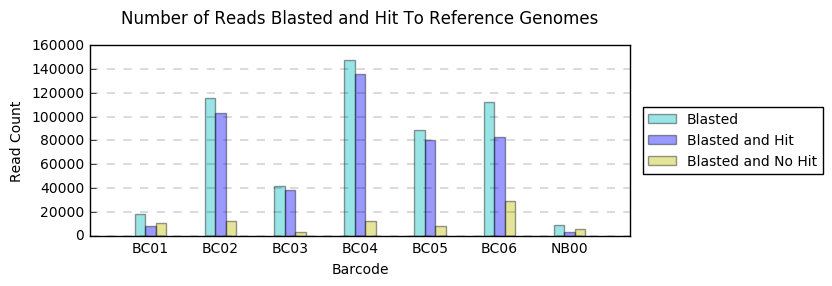

In [1094]:
#two qualitative variables - barcode, blasted vs no hit vs hit
#one quantitative - read count
n_groups = len(rgblasted_count_df_noall.index.values)

bar_labels = ['Blasted', 'Blasted and Hit', 'Blasted and No Hit']
counts = [tuple(rgblasted_count_df_noall['RGCount']),
          tuple(rgblasted_count_df_noall['RGHitYes']),
          tuple(rgblasted_count_df_noall['RGHitNo'])]

fig, ax = plt.subplots(figsize=(6.5,3))

index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.4
cycol = 'rgbcym'

for idx, (lbl, cnts) in enumerate(zip(bar_labels, counts)):
    plt.bar(index + bar_width*idx, cnts, bar_width,
                 alpha=opacity,
                 color=random.sample(cycol, 1),
                 label=lbl)
    
plt.xlabel('Barcode')
plt.ylabel('Read Count')
plt.title('Number of Reads Blasted and Hit To Reference Genomes', y=1.08)
plt.xticks(index + bar_width*1.5, tuple(rgblasted_count_df_noall.index.values))
plt.tick_params(right='off', top='off', bottom='off')
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10)
plt.grid(b=None, which='major', axis='y', linestyle='dashed', linewidth=0.2)
plt.margins(x=0.1)

plt.tight_layout()
plt.show()

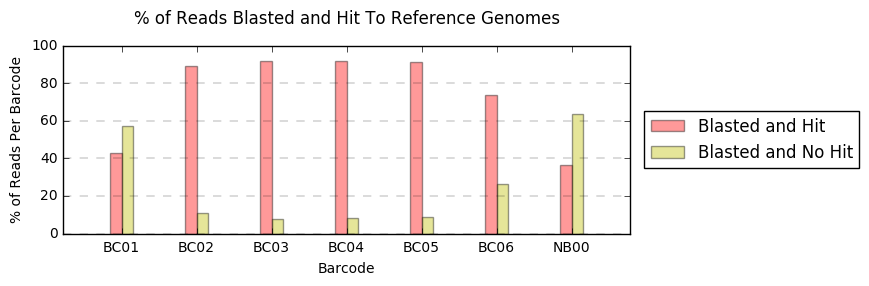

In [1097]:
#two qualitative variables - barcode, no hit vs hit
#one quantitative - read count
n_groups = len(rgblasted_count_df_noall.index.values)

bar_labels = ['Blasted and Hit', 'Blasted and No Hit']
counts = [tuple(rgblasted_count_df_noall['RGHitYes%']),
          tuple(rgblasted_count_df_noall['RGHitNo%'])]

fig, ax = plt.subplots(figsize=(6.5,3))

index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.4
cycol = 'rgbcym'

for idx, (lbl, cnts) in enumerate(zip(bar_labels, counts)):
    plt.bar(index + bar_width*idx, cnts, bar_width,
                 alpha=opacity,
                 color=random.sample(cycol, 1),
                 label=lbl)

plt.xlabel('Barcode')
plt.ylabel('% of Reads Per Barcode')
plt.title('% of Reads Blasted and Hit To Reference Genomes', y=1.08)
plt.xticks(index + bar_width, tuple(rgblasted_count_df_noall.index.values), y=-0.01)
plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=12)
plt.grid(b=None, which='major', axis='y', linestyle='dashed', linewidth=0.2)
plt.margins(x=0.1)

plt.tight_layout()
plt.show()

In [1152]:
ncbi = NCBITaxa()

In [ ]:
#Create a function that moves all NCBI best hit files to the ./blast/ncbibesthit folder, given input
#option to create folders for multiple search parameter settings (e.g. 000, 001)

In [1102]:
os.chdir(work_dir + 'blast/')
ncbiblast_file_names = [x for x in list(os.walk('./ncbibesthit', topdown=False))]
ncbiblast_file_names_flattened = list(flatten(ncbiblast_file_names))
ncbiblast_besthit_file_names = [x for x in ncbiblast_file_names_flattened if 'NCBI' in x]
ncbiblast_besthit_file_names.sort()

In [1147]:
#Extracts the blast id from the ncbiblast hit file names
ncbiblast_file_id_list = []
ncbiblast_file_type = '.besthit'
for file_name in ncbiblast_besthit_file_names:
    start = file_name.find(fasta_file_type)
    end = file_name.rfind(ncbiblast_file_type)
    ncbiblast_file_id_list.append(file_name[start+len(fasta_file_type):end])
ncbiblast_file_id = list(set(ncbiblast_file_id_list))[0]

In [1175]:
os.chdir(work_dir + 'blast/ncbibesthit')
ncbiblast_dfs_dict = {}
blast_output_parameters = ['qseqid', 'sseqid', 'evalue', 'bitscore', 'length', 
                           'pident', 'nident', 'sgi', 'sacc', 'staxids', 'sscinames', 
                           'scomnames', 'sskingdoms', 'barcode']
for besthit_file in ncbiblast_besthit_file_names:
    if '.besthit' in besthit_file:
        key = '' 
        key = besthit_file.split('.')[0][-4:]
        ncbiblast_dfs_dict[key] = pd.read_table(besthit_file, 
                                                delim_whitespace=False,
                                                names=blast_output_parameters) #hardcoded
for bcs in ncbiblast_dfs_dict.keys():
    ncbiblast_dfs_dict[bcs]['barcode'] = bcs

In [1176]:
#Combining the BC00 reads from BLAST
if 'BC00' in ncbiblast_dfs_dict.keys():
    ncbiblast_dfs_dict['BC00']['barcode'] = 'NB00'

#Joining the dataframes for individual barcodes together
ncbiblast_df_list = []
for bcs in ncbiblast_dfs_dict.keys():
    ncbiblast_df_list.append(ncbiblast_dfs_dict[bcs])
    
ncbiblast_df_joint = pd.concat(ncbiblast_df_list, axis=0, ignore_index=True)
ncbiblast_df_joint.sort_values('barcode', ascending=True, inplace=True)
ncbiblast_df_joint.reset_index(drop=True, inplace=True)

In [1178]:
#Function to generate taxonomy columns based on NCBITaxa results for NCBI hit dataframe, 
def search_rank_output_name_append_column(df, staxid_column, rank_search):
    """Input df, staxid_column from same df and rank_search (a desired taxonomic rank 
    from each staxid's lineage), outputs taxonomic name corresponding to rank_search or 'Unclassified' if
    unavailable and appends to df row by row"""
    rank_list = []
    for read_ind in range(0, len(staxid_column)):
        taxid = ''
        if ';' in str(staxid_column[read_ind]):
            taxid = staxid_column[read_ind].split(';')[0]
        else:
            taxid = staxid_column[read_ind]
        
        taxid_lineage = ''
        taxid_lineage = ncbi.get_lineage(taxid)
        
        names = ''
        names = ncbi.get_taxid_translator(taxid_lineage)
        
        ranks = ''
        ranks = ncbi.get_rank(taxid_lineage) #Dict
        
        ranks2names = ''
        ranks2names = {ranks[k]:names[k] for k in names.keys() & ranks}
        
        if rank_search in ranks2names.keys():
            rank_list.append(ranks2names[rank_search])#if rank in dict, print name
        else:
            rank_list.append('Unclassified')
    df[rank_search] = rank_list
# NOTE: Appending is always slow, try and find a better way e.g df.apply to a column based on staxids column

In [1179]:
#Appends columns to joint_NCBI_df_taxonomy corresponding to desired taxonomic ranks for metagenomic analysis
ncbiblast_df_joint_taxonomy = ncbiblast_df_joint.copy()
main_taxonomic_ranks = ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
for ranks in main_taxonomic_ranks:
    search_rank_output_name_append_column(ncbiblast_df_joint_taxonomy, 
                                          ncbiblast_df_joint_taxonomy['staxids'], 
                                          ranks)
    
#Removing unncessary columns from joint_NCBI_df_taxonomy
for columns in ['scomnames', 'sskingdoms', 'sscinames']:
    del ncbiblast_df_joint_taxonomy[columns] 

In [1180]:
ncbiblast_df_joint_taxonomy_adj = ncbiblast_df_joint_taxonomy.copy()

In [1181]:
def manually_adjust_ncbi_taxonomy(rank_select, entry_select, ranks_to_edit, new_entry):
    """Select dataframe entries to edit by a specific rank (rank_select) 
    and entry related to that rank (entry_select), 
    provide a list of ranks to edit for those selected entries (ranks_to_edit),
    replace these ranks with a new entry (new_entry)"""
    selection = (ncbiblast_df_joint_taxonomy_adj[rank_select] == entry_select)
    selected_tax_ranks = ranks_to_edit
    for ranks in selected_tax_ranks:
        ncbiblast_df_joint_taxonomy_adj[ranks][selection] = new_entry

In [1182]:
manually_adjust_ncbi_taxonomy('species', 
                            'Cloning vector lambda TXF97', 
                            ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus'], 
                            '(Cloning vector lambda TXF97)')

manually_adjust_ncbi_taxonomy('superkingdom', 
                            'Viruses', 
                            ['phylum', 'class'], 
                            'dsDNA viruses, no RNA stage')

/home/gamran/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1283]:
def generate_ncbi_taxonomy_pivot(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank counts, sorted by bcs"""
    pivot_table = tax_df.pivot_table(values='nident', 
                                            index=rank, 
                                            columns='barcode', 
                                            aggfunc='count', 
                                            fill_value=0, 
                                            margins=True)
    pivot_table.columns.name = None
    return pivot_table.sort_values(bcs, axis=0, ascending=False).head(n=num)

In [1282]:
def generate_ncbi_taxonomy_pivot_pc(tax_df, rank, bcs, num):
    """From tax_df, generate a pivot table listing num rank %, sorted ascending by bcs"""
    pivot_table_pc = tax_df.pivot_table(values='nident', 
                                        index=rank, 
                                        columns='barcode', 
                                        aggfunc='count', 
                                        fill_value=0, 
                                        margins=True)
    pivot_table_pc.columns.name = None
    
    for brcs in pivot_table_pc.columns:
        pivot_table_pc[str(brcs) + '%'] = pivot_table_pc[brcs].apply(lambda x: (x / pivot_table_pc[brcs].loc['All'])*100)
    for brcs in pivot_table_pc.columns:
        if '%' not in brcs:
            pivot_table_pc.drop(brcs, axis=1, inplace=True)
    pivot_table_pc.drop('All', axis=0, inplace=True)

    pivot_table_pc2 = pivot_table_pc.sort_values(str(bcs) + '%', axis=0, ascending=False)
    return pivot_table_pc2.applymap(lambda x: '%.3f' % x).head(n=num)

22905

In [1300]:
#count pivot table of dataframe with taxonomic columns, including reference genomes across all ranks: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_all_hits_pivot(rank, bcs, num, dropmaxspecies=False):
    """generate a pivot table listing num rank counts, sorted ascending by bcs"""
    blast_and_NCBI_df_list = [generate_ncbi_taxonomy_pivot(ncbiblast_df_joint_taxonomy_adj, rank, bcs, len(ncbiblast_df_joint_taxonomy_adj)), 
                    rgblast_df_joint_pivot.transpose()]
    blast_and_NCBI_hits = pd.concat(blast_and_NCBI_df_list)
    blast_and_NCBI_hits_sum = blast_and_NCBI_hits.groupby(blast_and_NCBI_hits.index).sum()
    
    max_genome = str(rgblast_df_joint_pivot_noall.ix['All'].idxmax(axis=1))
    
    if dropmaxspecies == True:
        blast_and_NCBI_hits_sum.loc['All'] = blast_and_NCBI_hits_sum.loc['All'] - blast_and_NCBI_hits_sum.loc[max_genome]
        blast_and_NCBI_hits_sum.drop(max_genome, axis=0, inplace=True)
    
    return blast_and_NCBI_hits_sum.sort_values(bcs, axis=0, ascending=False).head(n=num)

In [1301]:
# % pivot table of dataframe with taxonomic columns, including reference genomes across all ranks: 
#rows - rank names, columns - barcode, sorted by desired class
def generate_all_hits_pivot_pc(rank, bcs, num, dropmaxspecies=False):
    """generate a pivot table listing num rank %, sorted ascending by bcs"""
    blast_and_NCBI_df_list = [generate_ncbi_taxonomy_pivot(ncbiblast_df_joint_taxonomy_adj, rank, bcs, len(ncbiblast_df_joint_taxonomy_adj)), 
                    rgblast_df_joint_pivot.transpose()]
    blast_and_NCBI_hits = pd.concat(blast_and_NCBI_df_list)
    blast_and_NCBI_hits_sum = blast_and_NCBI_hits.groupby(blast_and_NCBI_hits.index).sum()
    
    max_genome = str(rgblast_df_joint_pivot_noall.ix['All'].idxmax(axis=1))
    
    if dropmaxspecies == True:
        blast_and_NCBI_hits_sum.loc['All'] = blast_and_NCBI_hits_sum.loc['All'] - blast_and_NCBI_hits_sum.loc[max_genome]
        blast_and_NCBI_hits_sum.drop(max_genome, axis=0, inplace=True)
    
    for brcs in blast_and_NCBI_hits_sum.columns:
        blast_and_NCBI_hits_sum[str(brcs) + '%'] = blast_and_NCBI_hits_sum[brcs].apply(lambda x: (x / blast_and_NCBI_hits_sum[brcs].loc['All'])*100)
    for brcs in blast_and_NCBI_hits_sum.columns:
        if '%' not in brcs:
            blast_and_NCBI_hits_sum.drop(brcs, axis=1, inplace=True)
    blast_and_NCBI_hits_sum.drop('All', axis=0, inplace=True)
    
    blast_and_NCBI_hits_sum2 = blast_and_NCBI_hits_sum.sort_values(str(bcs) + '%', axis=0, ascending=False)
    return blast_and_NCBI_hits_sum2.applymap(lambda x: '%.3f' % x).head(n=num)

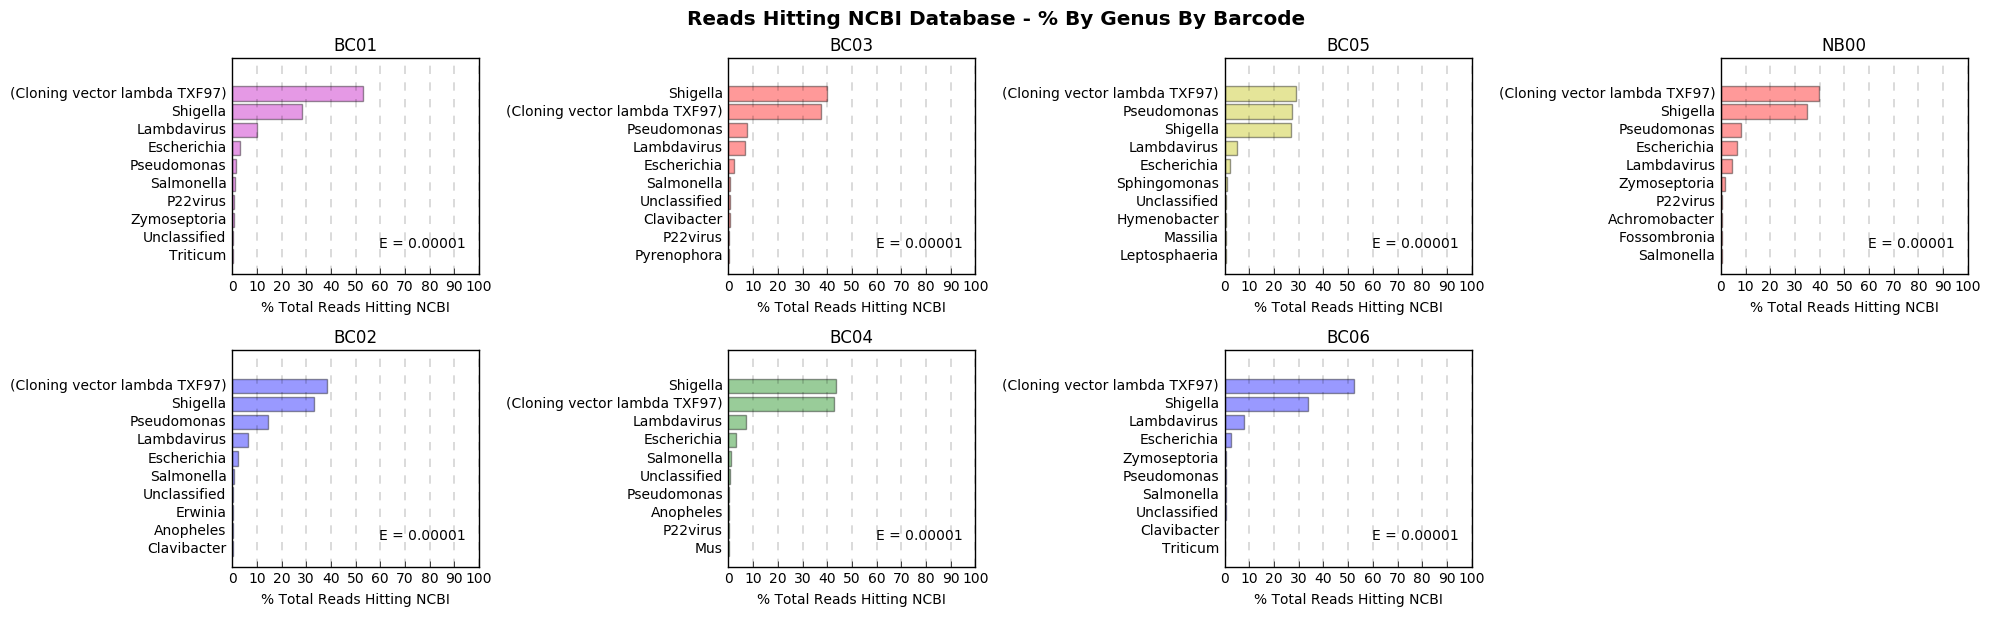

In [1286]:
#Assesses number of barcodes, generates necessary number of plots (even) and relevant indexing system
ncbiblast_barcodes = list(ncbiblast_df_joint_taxonomy_adj['barcode'].unique())

if len(list(ncbiblast_df_joint_taxonomy_adj['barcode'].unique())) % 2 == 0:
    no_of_subplots = len(ncbiblast_barcodes)
else:
    no_of_subplots = len(ncbiblast_barcodes) + 1

#Always 2 columns, bc-count/2 rows 
no_of_subplots_pair = [int(no_of_subplots/2), 2]

#Produce pairs of indices correlating to the coordinates of the subplots
subplot_coordinates = list(product(range(no_of_subplots_pair[0]), range(no_of_subplots_pair[1])))
subplot_coordinates_list = [list(l) for l in subplot_coordinates]
subplot_coordinates_list_rows = [i[0] for i in subplot_coordinates_list]
subplot_coordinates_list_columns = [i[1] for i in subplot_coordinates_list]

fig, ax = plt.subplots(no_of_subplots_pair[1], no_of_subplots_pair[0], figsize=(20, 6))
cycol = 'bgrcmy'

def applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, rank):
    labels = ''
    labels = tuple(generate_ncbi_taxonomy_pivot_pc(ncbiblast_df_joint_taxonomy_adj, rank, bcs, 10)[bcs + '%'].index)
    y_pos = ''
    y_pos = np.arange(len(labels))
    sizes = ''
    sizes = tuple([float(i) for i in generate_ncbi_taxonomy_pivot_pc(ncbiblast_df_joint_taxonomy_adj, rank, bcs, 10)[bcs + '%']])

    ax[ax_ind1, ax_ind2].barh(y_pos, sizes, align='center', alpha=0.4, color=random.choice(cycol))
    ax[ax_ind1, ax_ind2].set_yticks(y_pos)
    ax[ax_ind1, ax_ind2].set_yticklabels(labels)
    ax[ax_ind1, ax_ind2].tick_params(top="off", right="off", left="off")
    ax[ax_ind1, ax_ind2].set_xlabel('% Total Reads Hitting NCBI')
    ax[ax_ind1, ax_ind2].set_xticks(range(0, 110, 10))
    ax[ax_ind1, ax_ind2].set_title(bcs)
    ax[ax_ind1, ax_ind2].invert_yaxis()
    ax[ax_ind1, ax_ind2].grid(b=None, which='major', axis='x', linestyle='dashed', linewidth=0.2)
    ax[ax_ind1, ax_ind2].annotate('E = 0.00001', 
             xy=(1.06, 0.3), xycoords='axes fraction', fontsize=10, xytext=(-20, -30), textcoords='offset points', 
             ha='right', va='bottom')
    
def generateTaxSubplots(search_rank):
    for ax_ind1, ax_ind2, bcs, in zip(subplot_coordinates_list_columns, subplot_coordinates_list_rows, bc_list):
        applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, search_rank)    

    if len(list(ncbiblast_df_joint_taxonomy_adj['barcode'].unique())) != 0:
        plt.delaxes(ax[subplot_coordinates_list_columns[-1], subplot_coordinates_list_rows[-1]])
    
    plt.suptitle('Reads Hitting NCBI Database - % By ' + str(search_rank).title() + ' By Barcode', 
             fontsize='x-large',
             y=1.02,
             fontweight="bold")
    
generateTaxSubplots('genus')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.4, hspace=0.4)
plt.tight_layout()
#plt.savefig('/home/gamran/analysis/graph6.png', bbox_inches='tight')
plt.show()

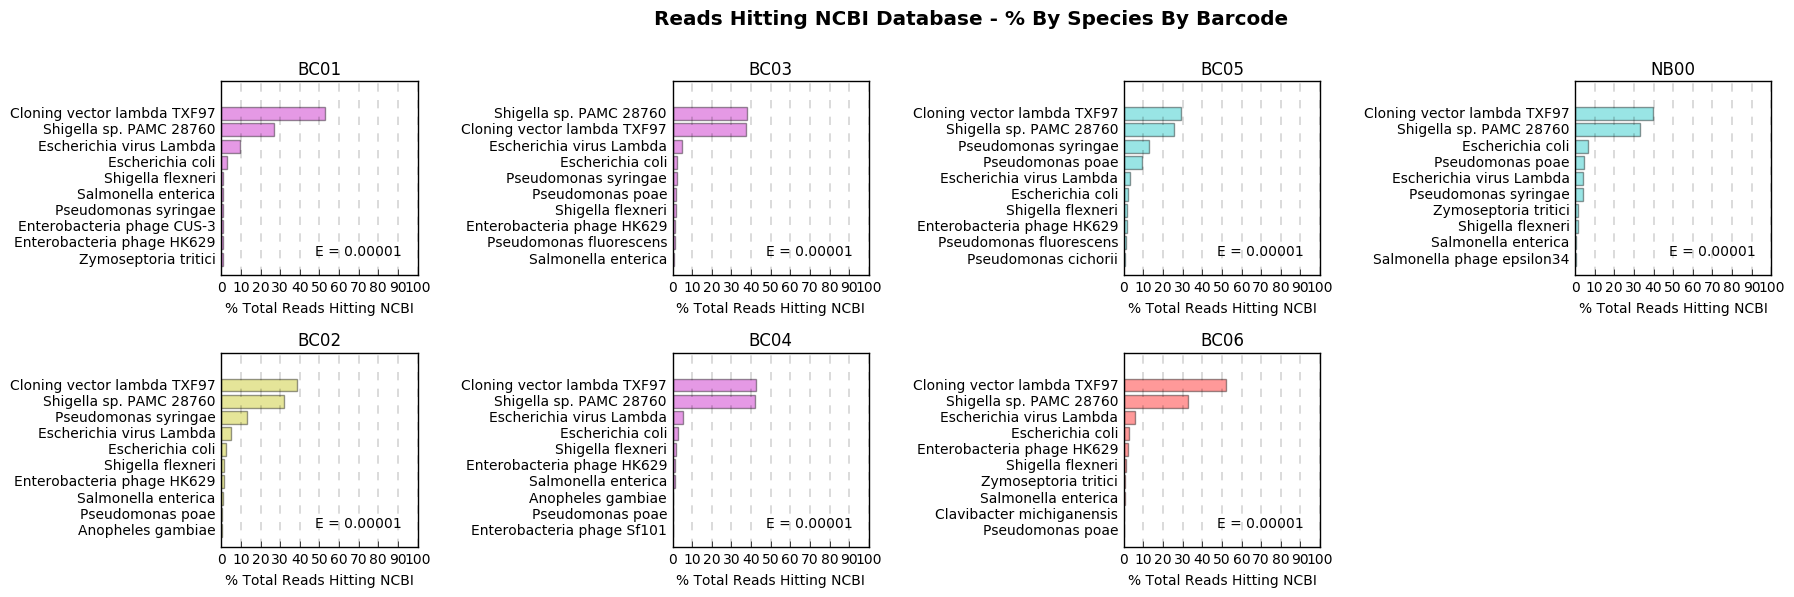

In [1287]:
fig, ax = plt.subplots(no_of_subplots_pair[1], no_of_subplots_pair[0], figsize=(20, 6))
cycol = 'bgrcmy'
generateTaxSubplots('species')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.3, hspace=0.4)
#plt.savefig('/home/gamran/analysis/graph10.png', bbox_inches='tight')
plt.show()

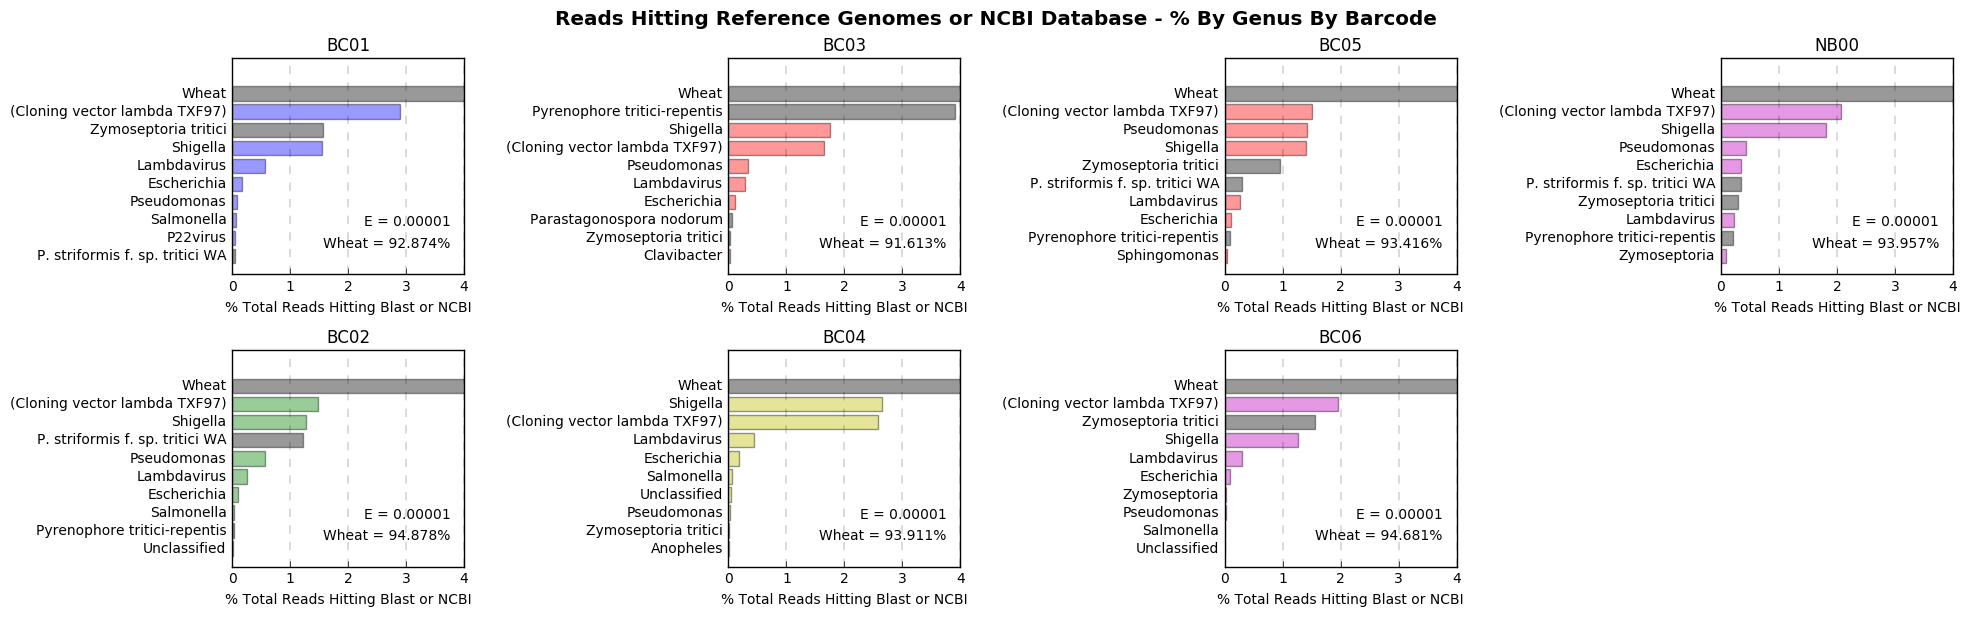

In [1307]:
#Assesses number of barcodes, generates necessary number of plots (even) and relevant indexing system
ncbiblast_barcodes = list(ncbiblast_df_joint_taxonomy_adj['barcode'].unique())

if len(list(ncbiblast_df_joint_taxonomy_adj['barcode'].unique())) % 2 == 0:
    no_of_subplots = len(ncbiblast_barcodes)
else:
    no_of_subplots = len(ncbiblast_barcodes) + 1

#Always 2 columns, bc-count/2 rows 
no_of_subplots_pair = [int(no_of_subplots/2), 2]

#Produce pairs of indices correlating to the coordinates of the subplots
subplot_coordinates = list(product(range(no_of_subplots_pair[0]), range(no_of_subplots_pair[1])))
subplot_coordinates_list = [list(l) for l in subplot_coordinates]
subplot_coordinates_list_rows = [i[0] for i in subplot_coordinates_list]
subplot_coordinates_list_columns = [i[1] for i in subplot_coordinates_list]

fig, ax = plt.subplots(no_of_subplots_pair[1], no_of_subplots_pair[0], figsize=(20, 6))
cycol = 'bgrcmy'
max_genome = str(rgblast_df_joint_pivot_noall.ix['All'].idxmax(axis=1))

def applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, rank):
    cycol_one = ''
    cycol_one = random.choice(cycol)
    labels = ''
    labels = tuple(generate_all_hits_pivot_pc(rank, bcs, 10, dropmaxspecies=False)[bcs + '%'].index)
    y_pos = ''
    y_pos = np.arange(len(labels))
    sizes = ''
    sizes = tuple([float(i) for i in generate_all_hits_pivot_pc(rank, bcs, 10, dropmaxspecies=False)[bcs + '%']])

    colors = []
    for name in labels:
        if name in list(rgblast_df_joint_pivot.columns):
            colors.append('k')
        else:
            colors.append(cycol_one)
    
    ax[ax_ind1, ax_ind2].barh(y_pos, sizes, align='center', alpha=0.4, color=colors)
    ax[ax_ind1, ax_ind2].set_yticks(y_pos)
    ax[ax_ind1, ax_ind2].set_yticklabels(labels)
    ax[ax_ind1, ax_ind2].tick_params(top="off", right="off", left="off")
    
    exact_xlim = int(float(generate_all_hits_pivot_pc(rank, 'BC04', len(ncbiblast_df_joint_taxonomy_adj), dropmaxspecies=False).drop(max_genome).values.max())+1)
    
    ax[ax_ind1, ax_ind2].set_xlim([0, exact_xlim])
    ax[ax_ind1, ax_ind2].set_xlabel('% Total Reads Hitting Blast or NCBI')
    ax[ax_ind1, ax_ind2].set_xticks(range(0, exact_xlim+1, 1))
    ax[ax_ind1, ax_ind2].set_title(bcs)
    ax[ax_ind1, ax_ind2].invert_yaxis()
    ax[ax_ind1, ax_ind2].grid(b=None, which='major', axis='x', linestyle='dashed', linewidth=0.2)
    ax[ax_ind1, ax_ind2].annotate(max_genome + ' = ' + str(sizes[0]) + '%', 
             xy=(1.06, 0.3), xycoords='axes fraction', fontsize=10, xytext=(-20, -30), textcoords='offset points', 
             ha='right', va='bottom')
    ax[ax_ind1, ax_ind2].annotate('E = 0.00001', 
             xy=(1.06, 0.4), xycoords='axes fraction', fontsize=10, xytext=(-20, -30), textcoords='offset points', 
             ha='right', va='bottom')
    
def generateTaxSubplots(search_rank):
    for ax_ind1, ax_ind2, bcs, in zip(subplot_coordinates_list_columns, subplot_coordinates_list_rows, bc_list):
        applyTaxPlotStyle(ax_ind1, ax_ind2, bcs, search_rank)    

    if len(list(ncbiblast_df_joint_taxonomy_adj['barcode'].unique())) != 0:
        plt.delaxes(ax[subplot_coordinates_list_columns[-1], subplot_coordinates_list_rows[-1]])
    
    plt.suptitle('Reads Hitting Reference Genomes or NCBI Database - % By ' + str(search_rank).title() + ' By Barcode', 
             fontsize='x-large',
             y=1.02,
             fontweight="bold")
    
generateTaxSubplots('genus')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.4, hspace=0.4)
plt.tight_layout()
#plt.savefig('/home/gamran/analysis/graph6.png', bbox_inches='tight')
plt.show()

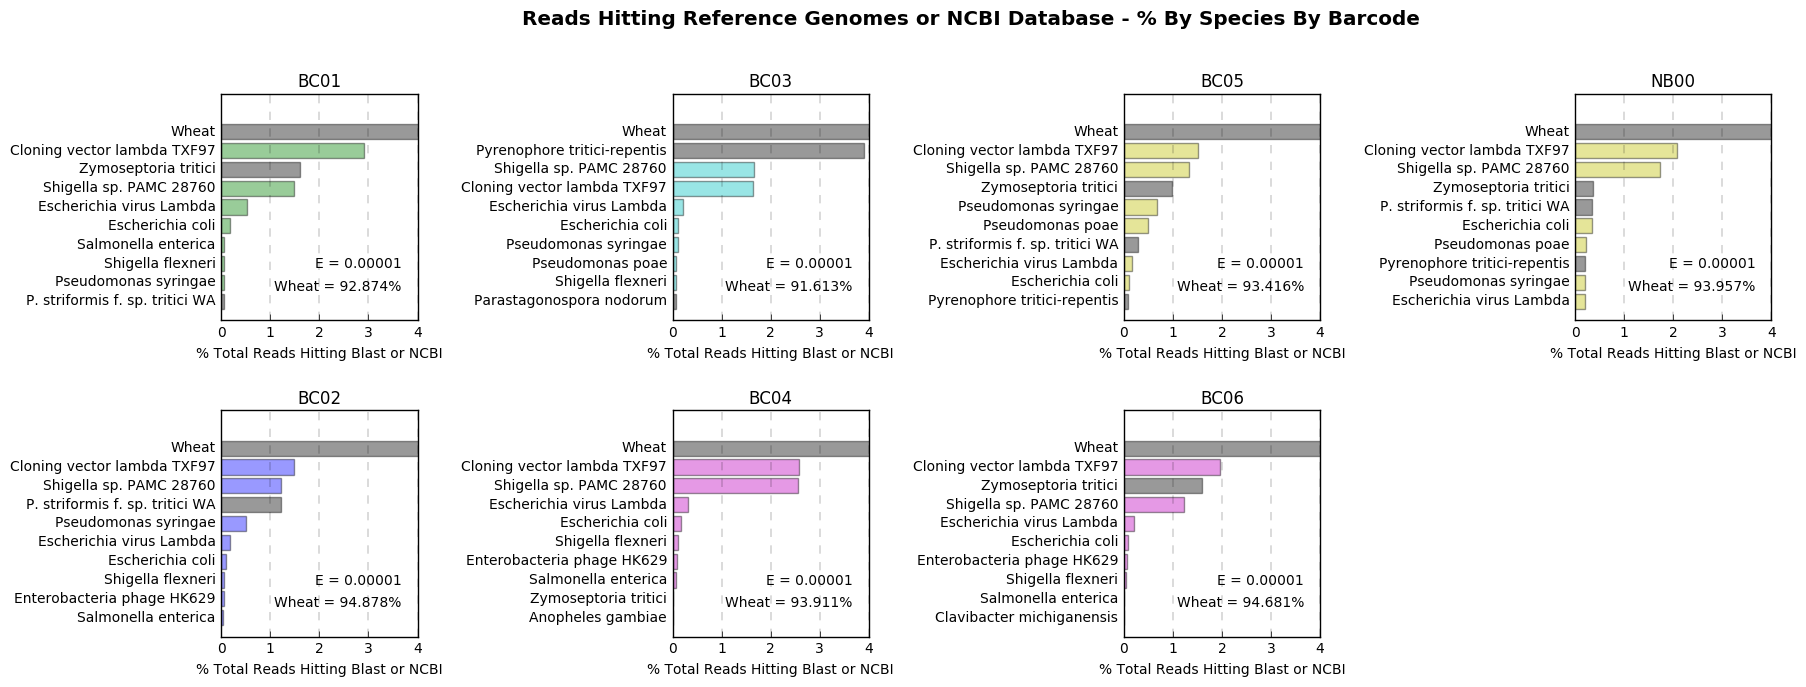

In [1311]:
fig, ax = fig, ax = plt.subplots(no_of_subplots_pair[1], no_of_subplots_pair[0], figsize=(20, 7))
cycol = 'bgrcmy'
generateTaxSubplots('species')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.3, hspace=0.4)
#plt.savefig('/home/gamran/analysis/graph10.png', bbox_inches='tight')
plt.show()

In [1313]:
ncbiblast_df_joint.qseqid

0        fff48c4d-c4b4-476d-9bfe-5ef907f8af97_Basecall_...
1        4ac290f8-a386-40a5-ac85-2bf6e04bdf48_Basecall_...
2        4bcd6024-2a79-40fd-ab26-415daf5df51b_Basecall_...
3        4cdc928b-9ca4-403d-a69d-08c2cb471cc7_Basecall_...
4        4dbb7b75-bb28-4d97-8eea-99793ed8cdd5_Basecall_...
5        4f87ce1b-e5c4-4642-8dc3-e1506c0386ec_Basecall_...
6        4fa5636f-14e0-49ea-b914-e6b667348e0c_Basecall_...
7        5004ce50-7801-4580-871c-f96e20111812_Basecall_...
8        51ba06de-340a-4928-a642-cf1099776c34_Basecall_...
9        51d404e6-945e-43fb-b990-ddc53addbb48_Basecall_...
10       522694d6-1e70-4687-a282-cbaa0802b6b2_Basecall_...
11       5232526b-3385-421a-a521-59988722ae46_Basecall_...
12       4a7e9d65-1bae-45c4-930c-673fe88ead84_Basecall_...
13       537e2da6-d349-42cc-9dbb-d54af2659cff_Basecall_...
14       55a8b2cd-dd21-4af4-8bf4-b23bb8e3ad11_Basecall_...
15       5734f1bc-a112-41e9-a4c8-2273702e85aa_Basecall_...
16       57575801-172f-4b82-8af2-8f9f12f83e57_Basecall_.

In [ ]:
os.chdir(work_dir + 'blast/rghitno')

In [1315]:
print(basecalled_fasta_file_id)
print(blast_hit_sample_id)
print(rgblasted_hit_id)
print(ncbiblast_file_id)
print(rgblast_file_id)
print(fasta_file_type)
print(rgblast_file_type)

1212_1D_barcoding_Wagga_
.blasthitsample_
.blasthit
.NCBI04052016
.WW_19121016
.fa
.blast.besthit


In [1317]:
rgblast_file_id + ncbiblast_file_id + rgblasted_hit_id + fasta_file_type

'.WW_19121016.NCBI04052016.blasthit.fa'

In [1329]:
def generate_ncbihit_fasta(bcs, ncbihit):
    """Takes basecalled.df, and list of read_ids from rgblast_df_joint. For a single barcode:
    - if rghit is yes, extract a fasta file with all the reads hitting the reference genomes to data/rghityes
    - if rghit is no, extract a fasta file with all the reads not hitting the reference genomes to data/rghitno"""
    os.chdir(work_dir + 'data/basecalled/')
    read_id_list = basecalled_df.groupby('Barcode')['Read_id'].get_group(bcs).tolist()
    ncbi_qseqid_list = ncbiblast_df_joint.groupby('barcode')['qseqid'].get_group(bcs).tolist()

    if ncbihit == 'Yes':
        ncbiblasted_hit_id = '.blasthit'
        ncbiblasthit_id = ncbiblast_file_id + ncbiblasted_hit_id + fasta_file_type
        ncbiblasthit_file = basecalled_fasta_file_id + bcs + ncbiblasthit_id
        
        if bcs == 'NB00':
            ncbihityes = []
            for badbcs in bad_barcodes:
                ncbihityes_NB00 = ''
                ncbihityes_NB00 = (rec for rec in SeqIO.parse(basecalled_fasta_file_id + str(badbcs) + fasta_file_type, 'fasta') if rec.id in ncbi_qseqid_list) 
                ncbihityes.extend(ncbihityes_NB00)
            count = ''
            count = SeqIO.write(ncbihityes, os.path.join(work_dir + 'data/rghitno/ncbihityes', ncbiblasthit_file), "fasta")
            print(count)
        else:
            ncbihityes = ''
            ncbihityes = (rec for rec in SeqIO.parse(basecalled_fasta_file_id + str(bcs) + fasta_file_type, 'fasta') if rec.id in ncbi_qseqid_list) 
            count = ''
            count = SeqIO.write(ncbihityes, os.path.join(work_dir + 'data/rghitno/ncbihityes', ncbiblasthit_file), "fasta")
            print(count)
            
    if ncbihit == 'No':
        noncbiblasted_hit_id = '.noblasthit'
        noncbiblasthit_id = ncbiblast_file_id + ncbiblasted_hit_id + fasta_file_type
        noncbiblasthit_file = basecalled_fasta_file_id + bcs + ncbiblasthit_id
        
        if bcs == 'NB00':
            ncbihitno = []
            for badbcs in bad_barcodes:
                ncbihitno_NB00 = ''
                ncbihitno_NB00 = (rec for rec in SeqIO.parse(basecalled_fasta_file_id + str(badbcs) + fasta_file_type, 'fasta') if rec.id not in ncbi_qseqid_list) 
                ncbihitno.extend(ncbihitno_NB00)
            count = ''
            count = SeqIO.write(ncbihitno, os.path.join(work_dir + 'data/rghitno/ncbihitno', noncbiblasthit_file), "fasta")
            print(count)
        else:
            ncbihitno = ''
            ncbihitno = (rec for rec in SeqIO.parse(basecalled_fasta_file_id + str(bcs) + fasta_file_type, 'fasta') if rec.id not in ncbi_qseqid_list) 
            count = ''
            count = SeqIO.write(ncbihitno, os.path.join(work_dir + 'data/rghitno/ncbihitno', noncbiblasthit_file), "fasta")
            print(count)

In [1331]:
for bcs in list(ncbiblast_df_joint.barcode.unique()):
    generate_ncbihit_fasta('BC02', 'Yes')


4127
4127
4127
4127
4127
4127
4127


In [ ]:
for bcs in list(ncbiblast_df_joint.barcode.unique()):
    generate_ncbihit_fasta(bcs, 'No')

array(['BC01', 'BC02', 'BC03', 'BC04', 'BC05', 'BC06', 'NB00'], dtype=object)

In [1065]:
whos

Variable                                    Type                Data/Info
-------------------------------------------------------------------------
SeqIO                                       module              <module 'Bio.SeqIO' from <...>s/Bio/SeqIO/__init__.py'>
access_dir_analysis                         NoneType            None
access_dir_blast                            NoneType            None
access_dir_data                             NoneType            None
all_barcodes                                list                n=101
analysis_summaries_path                     str                 /home/gamran/dirtreetest/analysis/summaries/
applyGroupHistograms                        function            <function applyGroupHistograms at 0x7fb31f9c6730>
assign_species_from_sseqid                  function            <function assign_species_<...>sseqid at 0x7fb31febd048>
ax                                          AxesSubplot         Axes(0.0974037,0.184259;0.881168x0.634296)
ax1_l

7787